In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
params = {} 
params["dataset_directory"] = "/raw-spiking-heidleberg-digits-80input/"
params["verbose"] = False

In [3]:
x_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_x_spikes.npy", allow_pickle = True)
y_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_y_spikes.npy", allow_pickle = True)

training_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "training_details.csv")
testing_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "testing_details.csv")


In [4]:
if params["verbose"]: print(training_details.head())
speaker_id = np.sort(training_details.Speaker.unique())
speaker_id = speaker_id = speaker_id.astype('int8')  #np where is fussy with int
if params["verbose"]: print(np.sort(testing_details.Speaker.unique()))
speaker = list(training_details.loc[:, "Speaker"])

In [5]:
speaker_id = np.sort(training_details.Speaker.unique())
speaker_id = speaker_id.astype('int8')  #np where is fussy with int
print(speaker_id)

[ 0  1  2  3  6  7  8  9 10 11]


In [6]:
speaker_x_indexes_list = [[] for _ in range(20)]
speaker_x_digit_2_indexes_list = [[] for _ in range(20)]

In [7]:
for s in speaker_id:
    speaker_x_indexes_list[s] = np.where(np.array(speaker) == s)[0]
    speaker_x_digit_2_indexes_list[s] = np.where(np.array(y_train[speaker_x_indexes_list[s]]) == 2)[0]

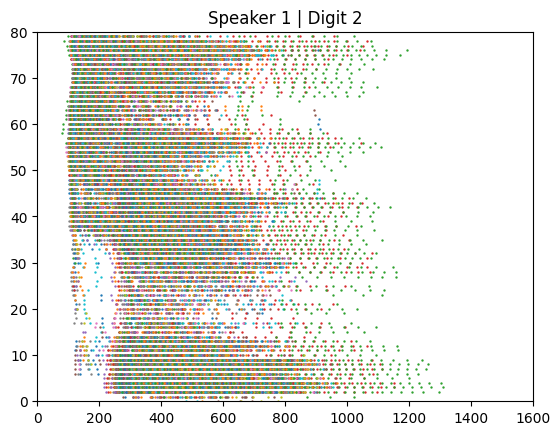

In [8]:
display_speaker = 1
for s in range(speaker_x_digit_2_indexes_list[display_speaker].shape[0]):

    plt.scatter(x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["t"], 
                x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["x"], 
                s = 0.5)

plt.ylim(0, 80)
plt.xlim(0, 1600)
plt.title(f"Speaker {display_speaker} | Digit 2")

plt.show()

In [9]:
print(speaker_id)

[ 0  1  2  3  6  7  8  9 10 11]


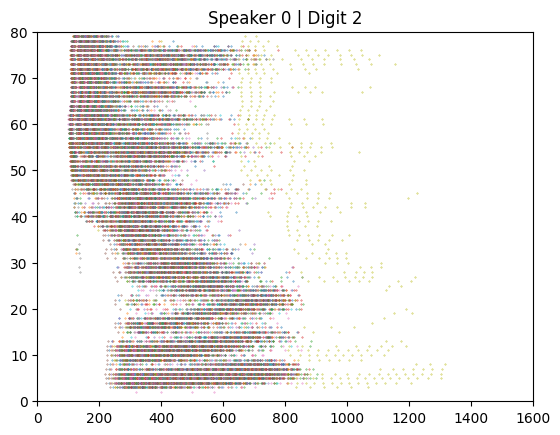

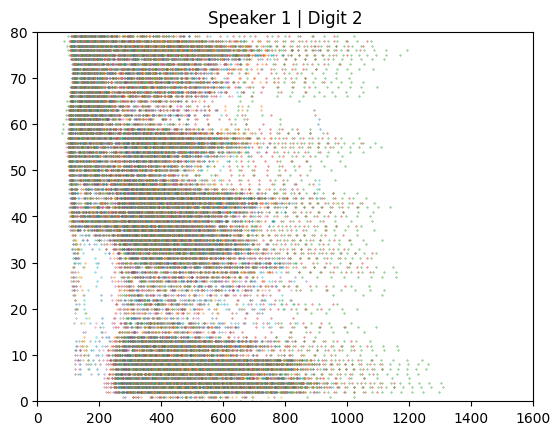

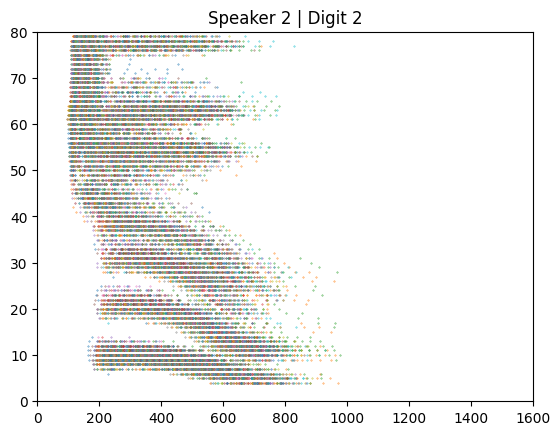

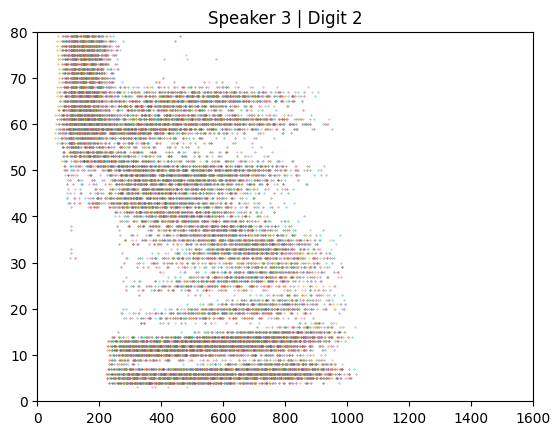

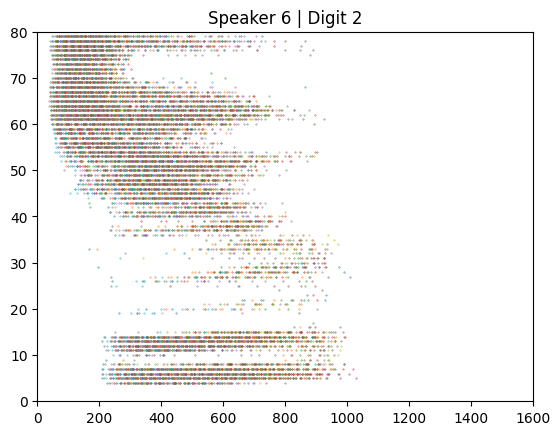

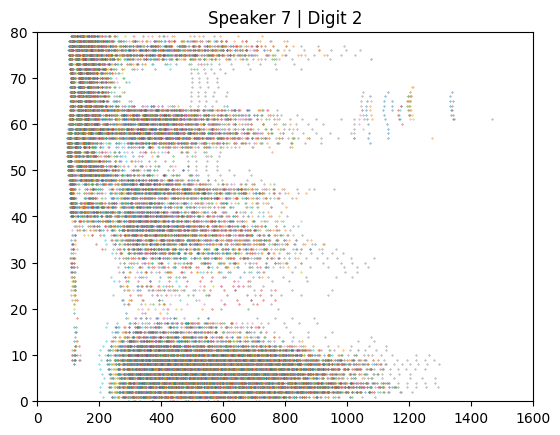

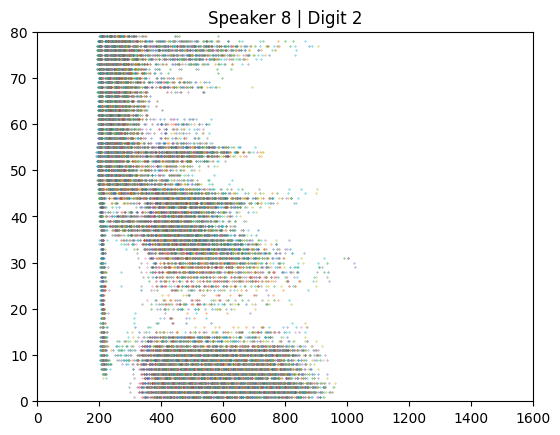

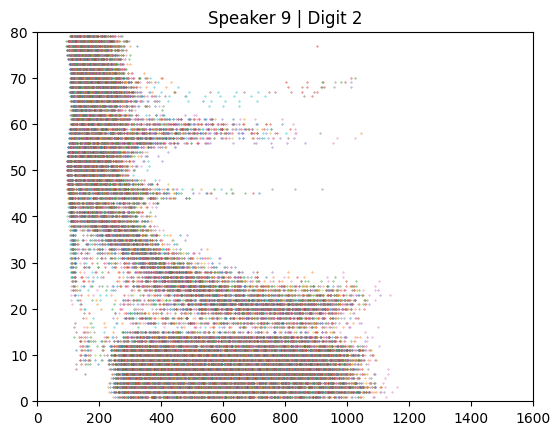

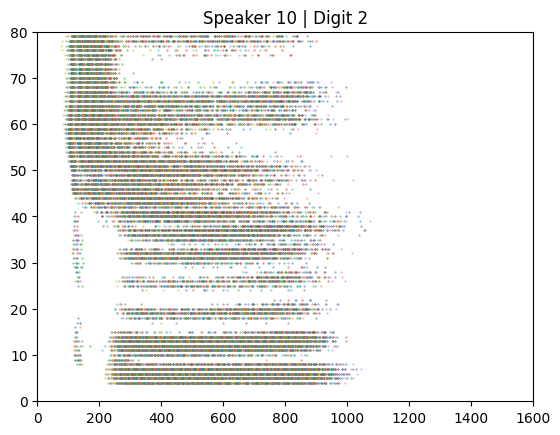

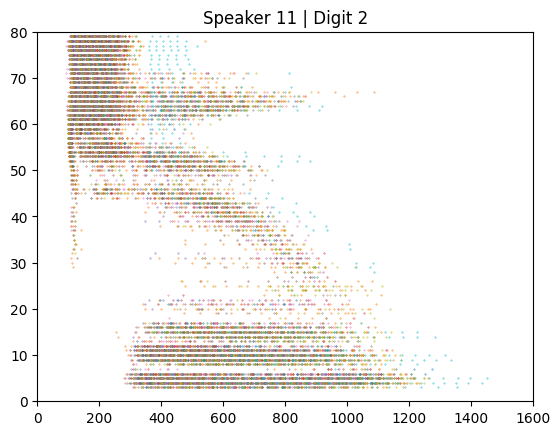

In [12]:
for display_speaker in speaker_id:

    #display_speaker = 1
    for s in range(speaker_x_digit_2_indexes_list[display_speaker].shape[0]):

        plt.scatter(x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["t"], 
                    x_train[speaker_x_indexes_list[display_speaker]][speaker_x_digit_2_indexes_list[display_speaker]][s]["x"], 
                    s = 0.1)

    plt.ylim(0, 80)
    plt.xlim(0, 1600)
    plt.title(f"Speaker {display_speaker} | Digit 2")

    plt.show()